# Final size comparisons

In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
from grab_data import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from grab_simulations import AvailableSims, available_r0s

mpl.rcParams['figure.dpi'] = 300

In [74]:
DATASET = 'CENSUS_LAD11'
r0s_available = len(available_r0s)
total_pop = get_population_sizes(DATASET).sum()

6

## Calculate final size

In [84]:
def total_final_size_distribution(simulation):
    return 1 - simulation[:, -1].sum(axis=1) / total_pop

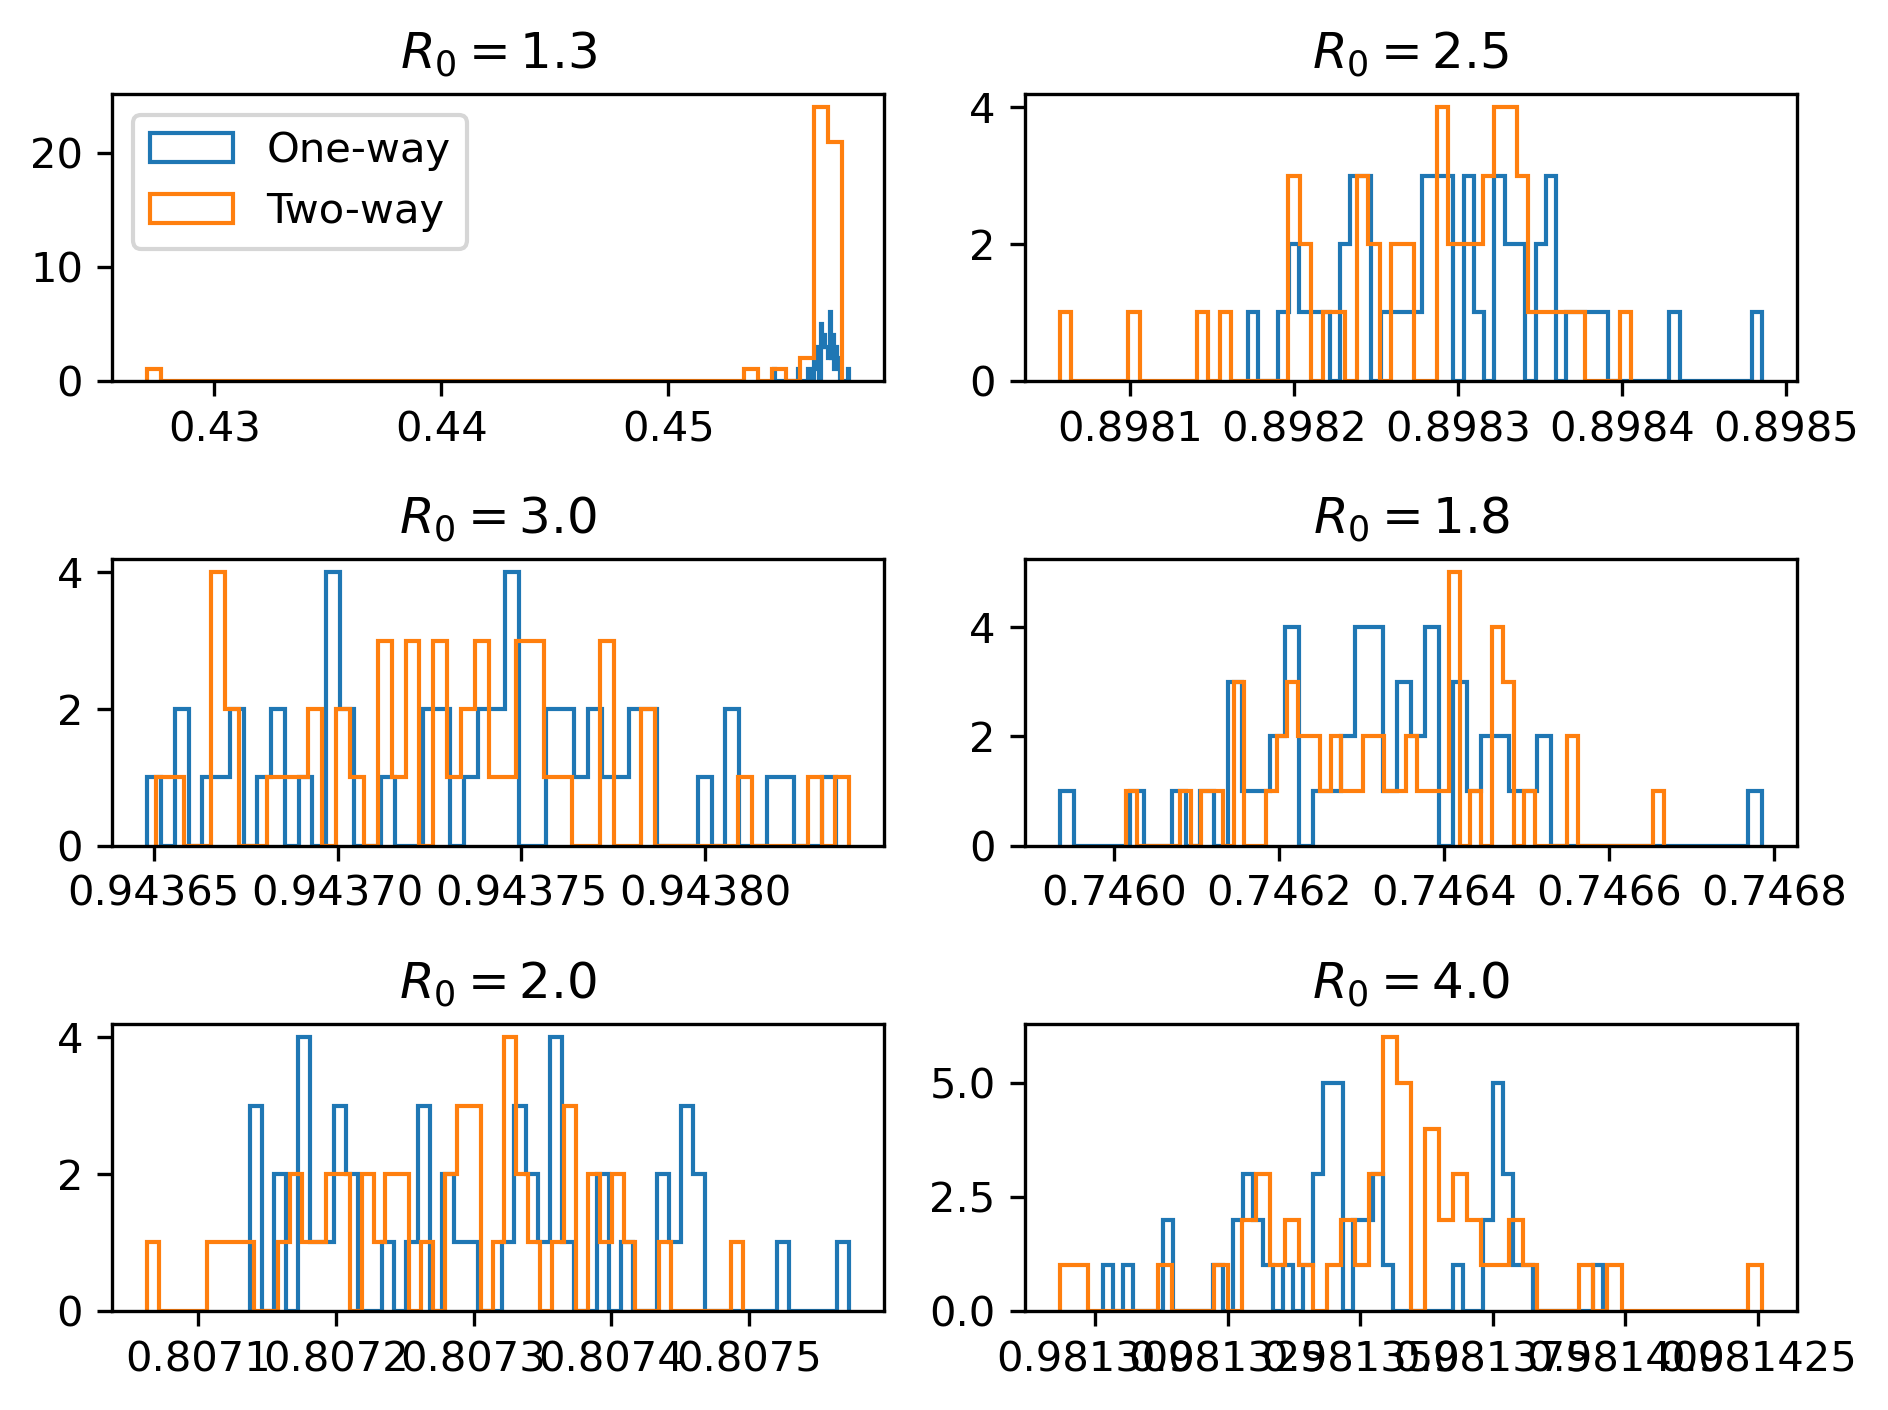

In [90]:
fig, ax = plt.subplots(nrows=3, ncols=2)
time_range = np.linspace(0, 200, 200 * 12)
i,j = 0,0
for sim in AvailableSims():
    one_way, two_way, r0 = sim
    one_way_final_sizes = total_final_size_distribution(one_way[0])
    two_way_final_sizes = total_final_size_distribution(two_way[0])
    ax[i,j].hist(one_way_final_sizes, label='One-way', histtype='step', bins=50)
    ax[i,j].hist(two_way_final_sizes, label='Two-way', histtype='step', bins=50)
    ax[i,j].set_title(f'$R_0 = {r0}$')
    i = (i+1)%3
    j = (j+1)%2
ax[0,0].legend()
fig.tight_layout()
plt.show()

## Patch total final size comparison

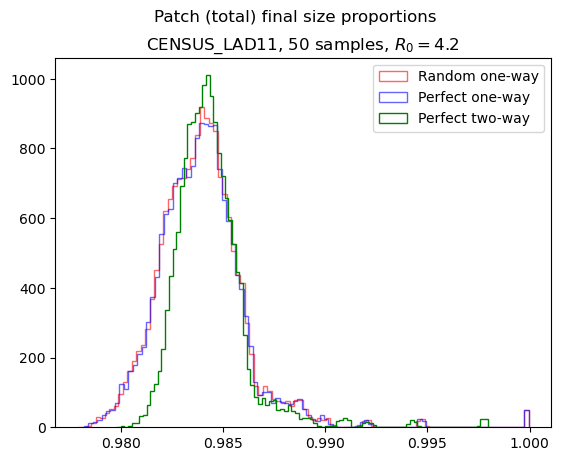

In [65]:
plt.hist(base_random_total_f.flatten(), label='Random one-way', color='r', alpha=0.6, bins=100, histtype='step')
plt.hist(base_perfect_total_f.flatten(), label='Perfect one-way', color='b', bins=100, alpha=0.6, histtype='step')
plt.hist(two_way_perfect_total_f.flatten(), label='Perfect two-way', color='g', bins=100, histtype='step')

plt.suptitle('Patch (total) final size proportions')
plt.title(f'{DATASET}, {samples} samples, $R_0 = {R0}$')
plt.legend()
plt.show()

## Overall final size comparison

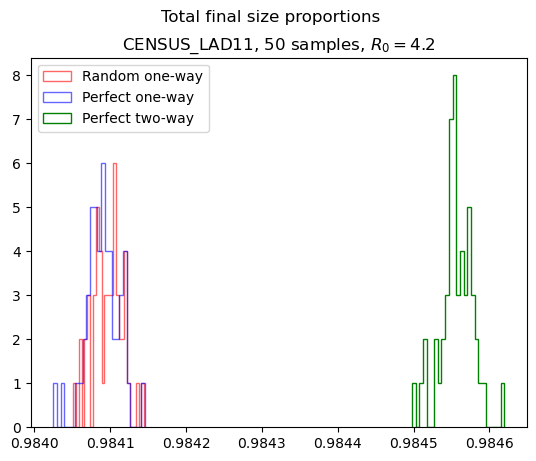

In [66]:
plt.hist((base_random_total_f * population_sizes[..., np.newaxis]).sum(axis=0) / total_pop, label='Random one-way',
         color='r', alpha=0.6, histtype='step', bins=25)
plt.hist((base_perfect_total_f * population_sizes[..., np.newaxis]).sum(axis=0) / total_pop, label='Perfect one-way',
         color='b', alpha=0.6, histtype='step', bins=25)
plt.hist((two_way_perfect_total_f * population_sizes[..., np.newaxis]).sum(axis=0) / total_pop, label='Perfect two-way',
         color='g', histtype='step', bins=25)
plt.legend()
plt.suptitle('Total final size proportions')
plt.title(f'{DATASET}, {samples} samples, $R_0 = {R0}$')
plt.show()

# Effect of $R_0$ on final size difference

In [8]:
r0s = [1.2, 2, 3]

In [9]:
base_params = dict(gamma=1 / incubation_period_days, psi=2 / 3, flow_matrix=flow_matrix,
                   population_sizes=population_sizes,
                   t_delta=1 / 12,
                   t_max=100, seed=0, seed_amount=1)
one_way_res = np.zeros(shape=(len(r0s), len(population_sizes), samples))

two_way_res = np.zeros(shape=(len(r0s), len(population_sizes), samples))
for index, r0 in enumerate(r0s):
    base_params['beta'] = r0 / incubation_period_days
    _, base_perfect_total_f = final_size_dist(base_simulate, 'perfect', base_params, k=samples)
    _, two_way_perfect_total_f = final_size_dist(two_way_simulate, 'perfect', base_params, k=samples)
    one_way_res[index] = base_perfect_total_f
    two_way_res[index] = two_way_perfect_total_f

KeyboardInterrupt: 

In [75]:
total_one_way = (one_way_res * population_sizes[np.newaxis, :, np.newaxis]).sum(axis=1) / total_pop
total_two_way = (two_way_res * population_sizes[np.newaxis, :, np.newaxis]).sum(axis=1) / total_pop

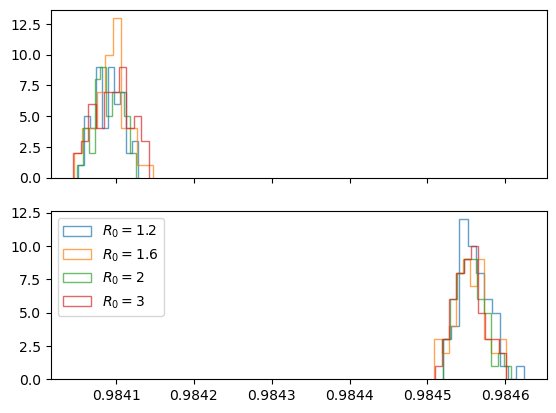

In [84]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
for index, r0 in enumerate(r0s):
    ax[0].hist(total_one_way[index], label=f'$R_0 = {r0}$', alpha=0.7, histtype='step', bins=10)
    ax[1].hist(total_two_way[index], label=f'$R_0 = {r0}$', alpha=0.7, histtype='step', bins=10)
plt.legend()
plt.show()